# 4. Classifying the P300

The first tutorial covered visualizing the P300 potential through an ERP plot. This tutorial covers the classification of the P300 potential. The EEG recording used here is made of a subject that is presented with a screen containing 6 icons. These icons were highlighted one by one. For each trial, each icon was highlighted a total of 10 times. The subject selected one of the icons and mentally counted the number of times the chosen icon was highlighted (which was ofcourse always 10), a task designed to keep him focussed on this icon. Every time the chosen icon, which I will refer to now as the target, was highlighted, a P300 potential occurs in the EEG signal. By determining which of the 6 icons corresponds to the largest P300, we can determine which of the icons was the target. This paradigm is a simple version of the famous P300 speller [1].

[1] Farwell, L. A., & Donchin, E. (1988). Talking off the top of your head: toward a mental prosthesis utilizing event-related brain potentials. *Electroencephalography and clinical neurophysiology*, 70(6), 510–523, http://www.ncbi.nlm.nih.gov/pubmed/2461285

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The data is stored in my public dropbox account and is 53 Mb in size. The following downloads it:

In [2]:
import urllib
urllib.urlretrieve('https://www.dropbox.com/s/xv64l9u3jg4kj0r/tutorial4-01.mat?dl=1', 'tutorial4-01.mat');

Loading the data should look very familiar by now:

In [3]:
import scipy.io
m = scipy.io.loadmat('tutorial4-01.mat')

EEG = m['EEG']
channel_names = [s.strip() for s in m['channel_names']]
event_onsets = m['event_onsets']
event_codes = m['event_codes']
targets = m['targets'][0] - 1 # -1 because the original list was 1-6, but numpy indexing is 0-5
sample_rate = m['sample_rate'][0][0]

ntrials = len(targets)
classes = unique(targets)
nclasses = len(classes)
nrepetitions = event_onsets.shape[1] / nclasses
nchannels = len(channel_names)

print 'Duration of recording is', EEG.shape[1] / float(sample_rate), 'seconds.'
print 'Number of EEG channels:', nchannels
print
print 'Number of trials:', ntrials
print 'Target icon for each trial:', targets
print 'Number of icons on the screen:', nclasses
print 'Number of times each icon was highlighted:', nrepetitions
print 'Shape of event matrix:', event_onsets.shape, 'ntrials x (nclasses * nrepetitions)'

Duration of recording is 265.0 seconds.
Number of EEG channels: 32

Number of trials: 12
Target icon for each trial: [0 1 2 3 2 4 3 0 4 1 5 5]
Number of icons on the screen: 6
Number of times each icon was highlighted: 10
Shape of event matrix: (12, 60) ntrials x (nclasses * nrepetitions)


Cutting the data into trials. This time, it becomes a 5 dimensional array. Take a look at the resulting dimensions reading the following description:

There are 12 trials. During each of these trials, data was collected for each of the 6 icons on the screen. Each icon was highlighted 10 times. The time-onsets when an icon was highlighted is called an epoch. For each epoch, the time interval 0.1 s *before* the onset until 1 s *after* the onset is extracted (1126 samples). The recording contains 32 channels.

In [4]:
window = [int(-0.1*sample_rate), int(1.0*sample_rate)]
nsamples = window[1] - window[0]

trials = np.zeros((nchannels, nsamples, nrepetitions, nclasses, ntrials))

for trial in range(ntrials):
    for cl in classes:
        onsets = event_onsets[trial, event_codes[trial,:] == (cl + 1)]
        for repetition, onset in enumerate(onsets):
            trials[:, :, repetition, cl, trial] = EEG[:, window[0]+onset:window[1]+onset]

print 'shape of trial matrix:', trials.shape

shape of trial matrix: (32, 1126, 10, 6, 12)


During the first tutorial, the EEG signal was already filtered in advance. This data is not, so we do it here. The function below applies a bandpass filter with a passband between 0.5 - 30 Hz. Also, each epoch is baselined. The baseline in this case is the mean EEG voltage starting from 0.1 s before the onset of the epoch until the onset, which we regard as 'resting EEG'. This baseline is substracted from the rest of the epoch, so the 'resing EEG' voltage is 0. Any changes to the resting EEG (such as the P300) as now relative to 0.

In [5]:
import scipy.signal

# Design and apply the bandpass filter
a, b = scipy.signal.iirfilter(3, [0.5/(sample_rate/2.0), 30/(sample_rate/2.0)])
trials_filt = scipy.signal.filtfilt(a, b, trials, axis=1)
    
# Calculate the baseline amplitude on the first 0.1 seconds (this corresponds to the time interval -0.1 - 0)
baseline = mean(trials_filt[:, 0:int(0.1*sample_rate), ...], axis=1)
trials_filt = trials_filt - tile(baseline[:, np.newaxis, :, :], (1, nsamples, 1, 1, 1))

Since we'll be using machine learning, split the data into a train and a test set 50-50, like we did in the previous tutorial:

In [6]:
train_split = 0.5
ntrain_trials = int(train_split * ntrials)
ntest_trials = ntrials - ntrain_trials

train = trials_filt[..., :ntrain_trials]
train_targets = targets[:ntrain_trials]

test = trials_filt[..., ntrain_trials:]
test_targets = targets[ntrain_trials:]

print 'channels x samples x repetitions x classes x trials'
print 'Training data:', train.shape
print 'Test data:    ', test.shape

channels x samples x repetitions x classes x trials
Training data: (32, 1126, 10, 6, 6)
Test data:     (32, 1126, 10, 6, 6)


The training data can be simplified a little bit. We don't care any longer which epoch belongs to which icon on the screen. We only care about epochs where the target was highlighted versus epochs where a nontarget was highlighted.

In [7]:
target_trials = []
nontarget_trials = []
for trial in range(ntrain_trials):
    for cl in range(nclasses):
        if cl == train_targets[trial]:
            target_trials.append( train[..., cl, trial] )
        else:
            nontarget_trials.append( train[..., cl, trial] )

# The shape of the data is now
# trials x channels x samples x repetitions
target_trials = array(target_trials)
nontarget_trials = array(nontarget_trials)

# Rearranging the axes a bit to
# channels x samples x repetitions x trials
target_trials = target_trials.transpose([1,2,3,0])
nontarget_trials = nontarget_trials.transpose([1,2,3,0])

print 'channels x samples x repetitions x trials'
print target_trials.shape
print nontarget_trials.shape

channels x samples x repetitions x trials
(32, 1126, 10, 6)
(32, 1126, 10, 30)


Before attempting classification, it is wise to first visualize the data. We do this in the same manner as during tutorial 1 with an ERP plot. So we bring back the `plot_eeg` function with some small improvements:

In [20]:
from matplotlib.collections import LineCollection

def plot_eeg(EEG, vspace=100, color='k'):
    '''
    Plot the EEG data, stacking the channels horizontally on top of each other.

    Arguments:
    EEG    - Array (channels x samples) containing the EEG data
    vspace - Amount of vertical space to put between the channels (default 100)
    color  - Color to draw the EEG in (default black)
    '''
    nchannels, nsamples = EEG.shape
    
    bases = vspace * arange(nchannels)
    EEG = EEG.T + bases
    
    # Calculate a timeline in seconds, knowing that the extracted time interval was -0.1 - 1.0 seconds
    time = arange(nsamples) / float(sample_rate)
    time -= 0.1

    # Plot EEG versus time as a line collection. This is a small improvement from the version in tutorial 1
    # and is useful for creating a figure legend later on. By default in a legend, every line gets one entry.
    # But in this EEG plot, multiple lines share the same entry, so we use a line collection.
    traces = LineCollection([zip(time, EEG[:, channel]) for channel in range(nchannels)], colors=color)
    gca().add_collection(traces)

    # Set the y limits of the plot to leave some spacing at the top and bottom
    ylim(-vspace, nchannels * vspace)
    
    # Set the x limits
    xlim(-0.1, 1.0)
    
    
    # Add gridlines to the plot
    grid(True)
    
    # Label the axes
    xlabel('Time (s)')
    ylabel('Channels')
    
    # The y-ticks are set to the locations of the electrodes. The international 10-20 system defines
    # default names for them.
    gca().yaxis.set_ticks(bases)
    gca().yaxis.set_ticklabels(channel_names)
    
    # Put a nice title on top of the plot
    title('EEG data')

Using the `plot_eeg` function to plot the ERPs of both classes (targets versus nontargets):

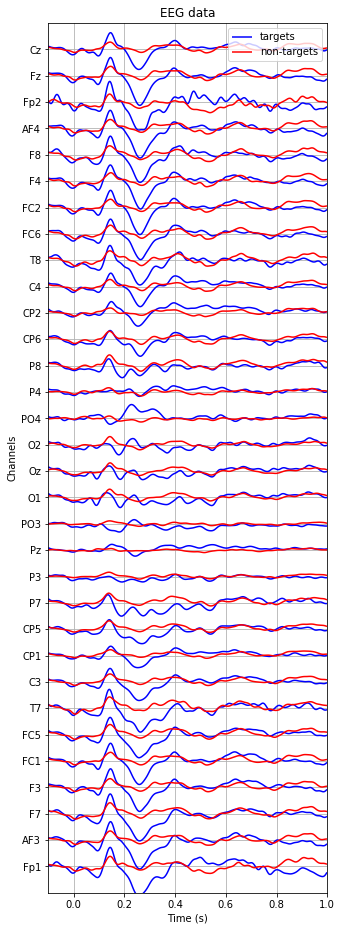

In [21]:
# First average over trials, then over repetitions
target_erp = mean(mean(target_trials, axis=3), axis=2)
nontarget_erp = mean(mean(nontarget_trials, axis=3), axis=2)

figure(figsize=(5,16))
plot_eeg(target_erp, color='b', vspace=10)
plot_eeg(nontarget_erp, color='r', vspace=10)
legend(['targets', 'non-targets'])

The familiar shape of the P300 is clearly visible on almost every channel.

Now for the classification. Classifying the P300 is relatively simple. We start by extracting some relevant features from the data, which we will feed into the machine learning algorithm. The feature extraction will proceed as follows:

1. For each trial, average across the repetitions, creating one ERP for each of the 6 classes.
1. Select 7 channels which show a strong P300 in the training data (done manually here)
1. For each channel, extract the average voltage for 20 time windows.

Now, each trial has $7 \times 20 = 140$ features.

The procedure is implemented in the `extract_features` function below:

In [22]:
def extract_features(epoch):
    '''
    Extract features form an epoch for classification.
    
    arguments:
        epoch - An array (channels x samples x repetitions) containing the epoch to extract features from.
    returns:
        A flat array containing the features.
    '''
    
    # Collect the features into this list
    features = []
    
    # First average over repetitions
    epoch = mean(epoch, axis=2)

    # Extract channels of interest
    channels_of_interest = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'P3', 'P4']
    #channels_of_interest = channel_names
    epoch = epoch[[channel_names.index(ch) for ch in channels_of_interest], :]
    
    # Finally, take the avarage value for 20 time windows
    nwindows = 20
    window_length = int(epoch.shape[1] / float(nwindows))
    for channel in range(len(channels_of_interest)):
        for window in range(nwindows):
            feature = mean(epoch[channel, window*window_length:(window+1)*window_length])
            features.append(feature)
    
    return array(features)

Applying the `extract_features` function to create the final training data:

In [23]:
target_features = vstack([extract_features(target_trials[...,i]) for i in range(target_trials.shape[-1])])
nontarget_features = vstack([extract_features(nontarget_trials[...,i]) for i in range(nontarget_trials.shape[-1])])

print 'observations x features'
print target_features.shape
print nontarget_features.shape

observations x features
(6, 140)
(30, 140)


As a classifier, we bring back the LDA used in the previous tutorial:

In [12]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    # Class priors: in this case, there are an unequal number of training
    # examples for each class. There are 5 times as many nontarget trials
    # as target trials.
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass2)
    
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
     
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W, b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (observations x features) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing the classification result for each trial
    '''
    return test.dot(W) - b

The code below applies the LDA classifier to determine for each trial, which of the 6 icons corresponds to the largest P300 potential:

In [13]:
def classify(trials, W, b):
    '''
    Apply the LDA classifier to the test trials.

    arguments:
        trials - An array (channels x samples x repetitions x classes x trials) containing the test trials.
        W      - The weights W as returned by train_lda()
        b      - The offsets b as returned by train_lda()
    returns:
        A list containing the predicted target icon for each trial.
    '''
    
    nclasses = trials.shape[3]
    ntrials = trials.shape[4]
    
    predicted_targets = []
    for trial in range(ntrials):
        # Feature extraction
        features = vstack([extract_features(test[:,:,:,cl,trial]) for cl in range(nclasses)])
        
        # Classification
        p = apply_lda(features, W, b)
        
        # Determine icon with the highest P300
        predicted_targets.append( argmin(p) )
        
    return array(predicted_targets)

Training the classifier on the training data, applying it on the test data:

In [14]:
W, b = train_lda(target_features, nontarget_features)
predicted_targets = classify(test, W, b)

print 'Predicted targets:', predicted_targets
print 'Real targets:     ', test_targets
print 'Accuracy: %.2f' % (len(flatnonzero(predicted_targets == test_targets)) / float(ntest_trials))

Predicted targets: [3 0 4 1 5 5]
Real targets:      [3 0 4 1 5 5]
Accuracy: 1.00


You see that with the first 6 trials as training data, we were able to correctly determine the target icon in the 6 remaining trials, using relatively simple techniques.